# Logistic equation with autoregressive order 1 (AR1) errors 

This example illustrates how specifying independent normal likelihoods for consecutive data points in a time series in which the errors show persistence can result in overly narrow posterior distributions, which often do not contain the true parameter value. We illustrate this by adding AR1 noise,

$$\epsilon_t = \rho \epsilon_{t-1} + v_t,$$

where $|\rho|<1$ and $v_t\sim \mathcal{N}(0,\sigma)$, to the solution of the logistic ODE, and then use a likelihood which assumes independent noise to infer the parameters of the logistic equation.

To avoid this issue, we recommend fitting a model with AR1 errors to datasets where there is persistent modelling or measurement error.

## Create fake data by integrating logistic ODE and adding AR1 noise to it

Import numpy library for vectors and matrices.

In [2]:
import numpy as np

Function to generate an AR1 error process, which starts at zero.

In [3]:
def AR1(rho, sigma, T):
    vX = np.zeros(T)
    for t in range(1,T):
        vX[t] = rho * vX[t-1] + np.random.normal(0,sigma)
    return vX

Generate and plot sample AR1 processes of length 200 across three different values of $\rho$, for $\sigma = 1$.

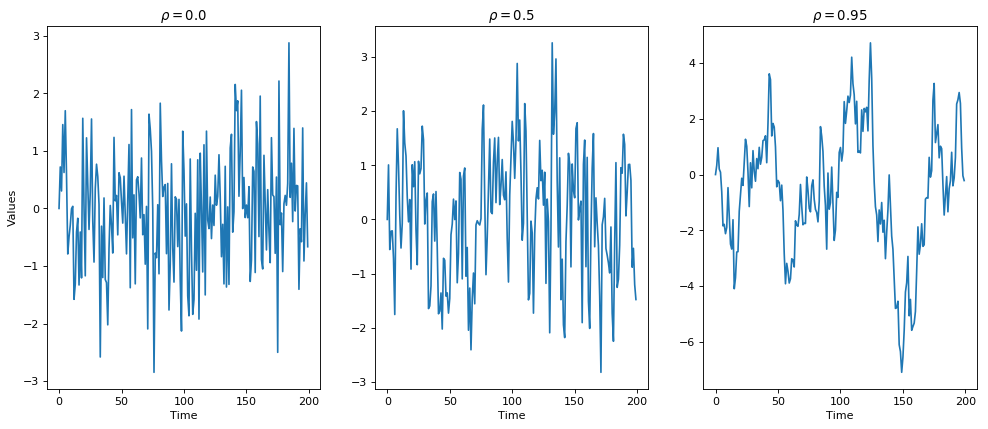

In [4]:
import matplotlib.pyplot as plt

T = 200
vRho = [0.00,0.50,0.95]
mError = np.zeros((T,len(vRho)))
k = 0
for rho in vRho:
    mError[:,k] = AR1(rho,1,T)
    k += 1

plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
# rho = 0
ax1 = plt.subplot(131)
ax1.plot(mError[:,0])
ax1.set_xlabel('Time')
ax1.set_ylabel('Values')
ax1.set_title(r'$\rho = $' + str(vRho[0]))

# rho = 0.5
ax2 = plt.subplot(132)
ax2.plot(mError[:,1])
ax2.set_xlabel('Time')
ax2.set_title(r'$\rho = $' + str(vRho[1]))

# rho = 0.95
ax3 = plt.subplot(133)
ax3.plot(mError[:,2])
ax3.set_xlabel('Time')
ax3.set_title(r'$\rho = $' + str(vRho[2]))

plt.show()

Solve logistic equation (todo: do this using PINTS!).

In [5]:
import scipy.integrate as integrate
def logisticDerivative(x, t, theta):
    r = theta[0]
    k = theta[1]
    dxdt = r * x * (1 - x / k)
    return dxdt
def solveLogisticODE(r, k, x0, T, diff):
    theta = [r,k]
    x = integrate.odeint(logisticDerivative, x0, np.linspace(0,T,int(np.round(T/diff))), args = (theta,))
    return x

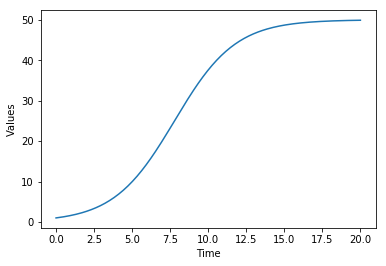

In [6]:
T = 20
diff = 0.1
nSteps = int(np.round(T/diff))
t = np.linspace(0,T,nSteps)
x = solveLogisticODE(0.5,50,1,T,diff)
plt.plot(t,x)
plt.xlabel('Time')
plt.ylabel('Values')
plt.show()

Add AR1 noise to logistic solution.

In [7]:
def logisticAR1(r, k, x0, rho, sigma, T, diff):
    nSteps = int(np.round(T/diff))
    x = solveLogisticODE(r, k, x0, T, diff)
    error = AR1(rho, sigma, nSteps)
    xNoise = np.transpose(x) + error
    return xNoise.flatten()

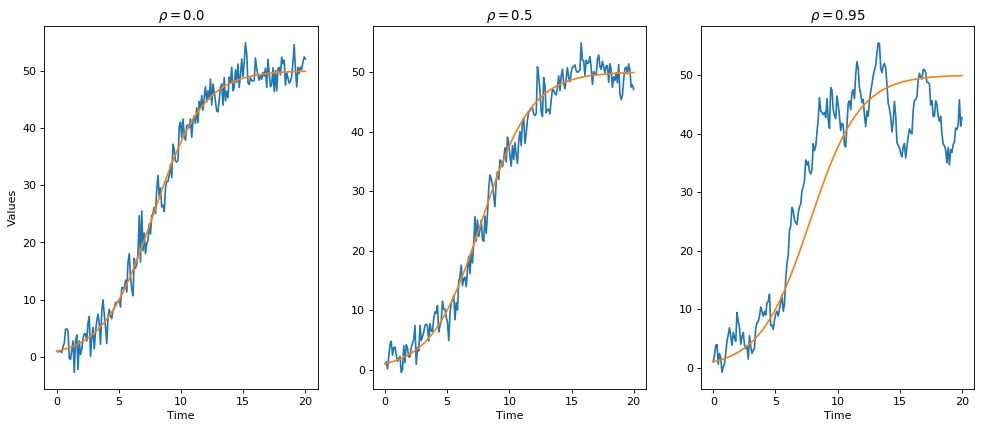

In [8]:
T = 20
diff = 0.1
nSteps = int(np.round(T/diff))
t = np.linspace(0,T,nSteps)
x = solveLogisticODE(0.5,50,1,T,diff)
mX = np.zeros((nSteps, 3))
k = 0
for rho in vRho:
    mX[:,k] = logisticAR1(0.5,50,1,rho,2,20,0.1)
    k += 1

plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
# rho = 0
ax1 = plt.subplot(131)
ax1.plot(t,mX[:,0])
ax1.plot(t,x)
ax1.set_xlabel('Time')
ax1.set_ylabel('Values')
ax1.set_title(r'$\rho = $' + str(vRho[0]))

# rho = 0.5
ax2 = plt.subplot(132)
ax2.plot(t,mX[:,1])
ax2.plot(t,x)
ax2.set_xlabel('Time')
ax2.set_title(r'$\rho = $' + str(vRho[1]))

# rho = 0.95
ax3 = plt.subplot(133)
ax3.plot(t,mX[:,2])
ax3.plot(t,x)
ax3.set_xlabel('Time')
ax3.set_title(r'$\rho = $' + str(vRho[2]))
plt.show()

## Use naive probability model which assumes independent errors to infer parameters in Stan

Generate sample data, where $r = 0.5$, $k = 50$, $\rho = 0.95$, $\sigma = 2$, $T = 20$ and $diff = 0.1$

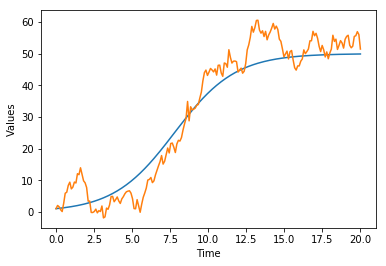

In [9]:
r = 0.5; k = 50;
x = logisticAR1(r,k,1,0.95,2,20,0.1)
xODE = solveLogisticODE(r,k,1,T,diff)
fake_data = {'T': len(t),
             't0': -0.0001,
             'ts': t,
              'y': x}
plt.plot(t,xODE)
plt.plot(t,x)
plt.xlabel('Time')
plt.ylabel('Values')
plt.show()

In [10]:
import pystan

naive_model = """
// define derivative function to solve ODE in Stan
functions {
  real[] logisticDerivative(real t,real[] y,real[] theta,real[] x_r,int[] x_i) {
    real dydt[1];
    dydt[1] = theta[1] * y[1] * (1 - theta[2] * y[1]);
    return dydt;
  }
}

data {
  int<lower=1> T;
  real t0;
  real ts[T];
  vector[T] y;
}

transformed data {
  real x_r[0];
  int x_i[0];
}

parameters {
  real<lower=0,upper=2> theta[2];
  real<lower=0> sigma;
  real<lower=0,upper=10> y0[1];
}

model {
  // solve logistic equation
  real y_hat[T,1];
  y_hat = integrate_ode_rk45(logisticDerivative, y0, t0, ts, theta, x_r, x_i);
  
  // likelihood
  for(t in 2:T){
    y[t] ~ normal(y_hat[t,1], sigma);
  }
  
  // priors
  theta[1] ~ normal(1,1);
  theta[2] ~ normal(1,1);
  sigma ~ normal(0,1);
  y0 ~ normal(5,2);
}
"""

stan_naive_model = pystan.StanModel(model_code=naive_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5d0fa82d9b58cc14ebf297c3e49131bf NOW.


In [11]:
fit_naive = stan_naive_model.sampling(data=fake_data, iter=1000, chains=4)
fit_naive

Inference for Stan model: anon_model_5d0fa82d9b58cc14ebf297c3e49131bf.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[0]   0.71  1.2e-3   0.03   0.65   0.69   0.71   0.74   0.79  826.0    1.0
theta[1]   0.02  5.3e-6 1.7e-4   0.02   0.02   0.02   0.02   0.02 1038.0    nan
sigma      3.86  5.8e-3   0.19    3.5   3.73   3.85   3.98   4.26 1116.0    1.0
y0[0]      0.15  1.4e-3   0.04   0.08   0.12   0.14   0.18   0.24  870.0    1.0
lp__     -391.1    0.05   1.49 -394.8 -391.9 -390.8 -390.0 -389.2  797.0   1.01

Samples were drawn using NUTS at Wed Nov 22 15:00:48 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

## Use probability model which assumes AR1 errors to infer parameters

In [12]:
AR1_model = """
// define derivative function to solve ODE in Stan
functions {
  real[] logisticDerivative(real t,real[] y,real[] theta,real[] x_r,int[] x_i) {
    real dydt[1];
    dydt[1] = theta[1] * y[1] * (1 - theta[2] * y[1]);
    return dydt;
  }
}

data {
  int<lower=1> T;
  real t0;
  real ts[T];
  vector[T] y;
}

transformed data {
  real x_r[0];
  int x_i[0];
}

parameters {
  real<lower=0,upper=2> theta[2];
  real<lower=0> sigma;
  real<lower=0,upper=10> y0[1];
  real<lower=0,upper=0.99> rho;
}

model {
  // solve logistic equation
  real y_hat[T,1];
  y_hat = integrate_ode_rk45(logisticDerivative, y0, t0, ts, theta, x_r, x_i);
  
  // likelihood
  for(t in 2:T){
    real error_t_minus_1 = y[t-1] - y_hat[t-1,1];
    y[t] ~ normal(y_hat[t,1] + rho * error_t_minus_1, sigma);
  }
  
  // priors
  theta[1] ~ normal(1,1);
  theta[2] ~ normal(1,1);
  rho ~ normal(0.0,0.5);
  sigma ~ normal(0,1);
  y0 ~ normal(5,2);
}
"""

stan_AR1_model = pystan.StanModel(model_code=AR1_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e6678b40428d7cea995f2028f09942eb NOW.


In [13]:
fit_AR1 = stan_AR1_model.sampling(data=fake_data, iter=1000, chains=4)
fit_AR1

Inference for Stan model: anon_model_e6678b40428d7cea995f2028f09942eb.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[0]    0.5    0.02   0.18   0.23   0.37   0.47   0.62   0.87  149.0   1.01
theta[1]   0.02  3.4e-4 4.5e-3   0.01   0.02   0.02   0.02   0.03  173.0   1.01
sigma      1.91  6.1e-3    0.1   1.74   1.84   1.91   1.98   2.12  265.0   1.01
y0[0]      2.04    0.14   2.03   0.05   0.35   1.29   3.34   6.94  212.0   1.01
rho        0.94  3.6e-3   0.04   0.85   0.91   0.94   0.97   0.99  121.0   1.02
lp__     -243.6    0.19   2.61 -250.3 -245.0 -243.1 -241.7 -240.0  197.0   1.02

Samples were drawn using NUTS at Wed Nov 22 15:03:33 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

## Compare results from naive and AR1 models in terms of the posteriors for r
The AR1 model posterior has greater uncertainty and less bias than the naive case.

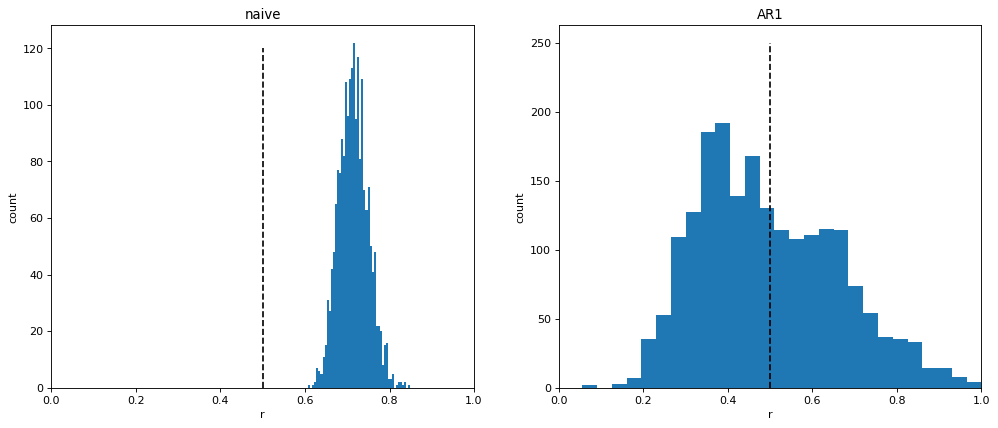

In [15]:
# extract data from stanfit objects
lNaive = fit_naive.extract(permuted=True)
rk_naive = lNaive['theta']
r_naive = rk_naive[:,0]
k_naive = rk_naive[:,1]
lAR1 = fit_AR1.extract(permuted=True)
rk_AR1 = lAR1['theta']
r_AR1 = rk_AR1[:,0]
k_AR1 = rk_AR1[:,1]

plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
# naive plot
ax1 = plt.subplot(121)
ax1.hist(r_naive,50)
ax1.plot((0.5,0.5),(0,120),'k--')
ax1.set_xlim([0,1])
ax1.set_xlabel('r')
ax1.set_ylabel('count')
ax1.set_title('naive')

# AR1 plot
ax2 = plt.subplot(122)
ax2.hist(r_AR1,50)
ax2.plot((0.5,0.5),(0,250),'k--')
ax2.set_xlim([0,1])
ax2.set_xlabel('r')
ax2.set_ylabel('count')
ax2.set_title('AR1')

plt.show()

## To diagnose an issue with the naive model, look at residual autocorrelation
A model fitting the data well should have little structure in the residuals. We now capture the vector residuals in each iteration of sampling, then use this to calculate an overall autocorrelation function.

In [50]:
naive_model1 = """
// define derivative function to solve ODE in Stan
functions {
  real[] logisticDerivative(real t,real[] y,real[] theta,real[] x_r,int[] x_i) {
    real dydt[1];
    dydt[1] = theta[1] * y[1] * (1 - theta[2] * y[1]);
    return dydt;
  }
}

data {
  int<lower=1> T;
  real t0;
  real ts[T];
  vector[T] y;
}

transformed data {
  real x_r[0];
  int x_i[0];
}

parameters {
  real<lower=0,upper=2> theta[2];
  real<lower=0> sigma;
  real<lower=0,upper=10> y0[1];
}

model {
  // solve logistic equation
  real y_hat[T,1];
  y_hat = integrate_ode_rk45(logisticDerivative, y0, t0, ts, theta, x_r, x_i);
  
  // likelihood
  for(t in 2:T){
    y[t] ~ normal(y_hat[t,1], sigma);
  }
  
  // priors
  theta[1] ~ normal(1,1);
  theta[2] ~ normal(1,1);
  sigma ~ normal(0,1);
  y0 ~ normal(5,2);
}

// use section to capture errors
generated quantities{
  real y_gen[T];
  real y_hat1[T,1];
  real vErr[T];
  vErr[1] = 0;
  y_gen[1] = y0[1];
  y_hat1 = integrate_ode_rk45(logisticDerivative, y0, t0, ts, theta, x_r, x_i);
  for(t in 2:T){
    y_gen[t] = normal_rng(y_hat1[t,1], sigma);
    vErr[t] = y[t] - y_gen[t];
  }
}
"""
stan_naive_model1 = pystan.StanModel(model_code=naive_model1)
fit_naive1 = stan_naive_model1.sampling(data=fake_data, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_503d0a7aa125ef89390ad74a9ee269fe NOW.


There is substantial persistence in the residuals from the naive model, evident from both the plots of the individual residual series, and also the autocorrelation function.

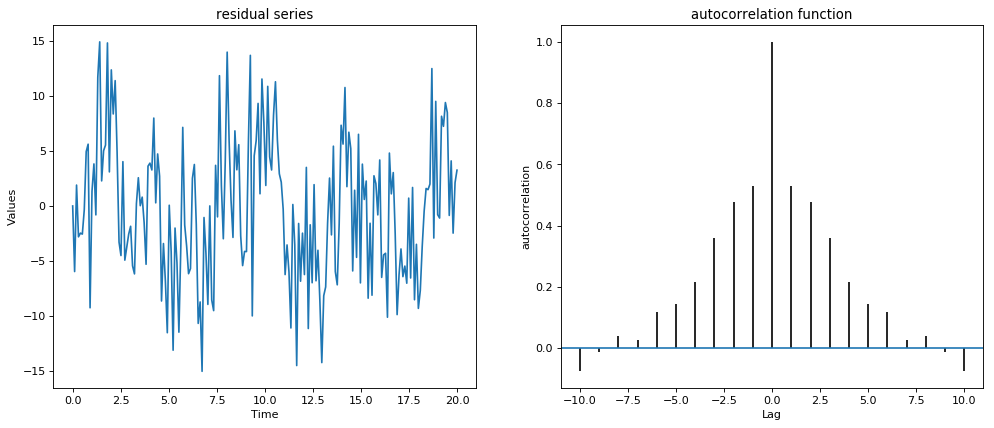

In [64]:
# extract data from stanfit objects
lNaive1 = fit_naive1.extract(permuted=True)
mErr = lNaive1['vErr']

plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
# plot of one residual series
ax1 = plt.subplot(121)
ax1.plot(t,mErr[1,:])
ax1.set_xlabel('Time')
ax1.set_ylabel('Values')
ax1.set_title('residual series')

# plot of autocorrelation function
ax2 = plt.subplot(122)
ax2.acorr(mErr[2,:])
ax2.set_xlabel('Lag')
ax2.set_ylabel('autocorrelation')
ax2.set_title('autocorrelation function')
plt.show()